<a href="https://colab.research.google.com/github/MCalenda/Q-DELOREAN/blob/main/notebooks/w2v_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SE4AI-Quantum/Q-DELOREAN

Mounted at /content/drive
/content/drive/MyDrive/SE4AI-Quantum/Q-DELOREAN


## Import Libraries and Frameworks

In [2]:
import pandas as pd
import numpy as np


from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import np_utils

## Load data

In [3]:
DATASET_PATH = 'data/processed/promise-reclass_normalized.csv'
df = pd.read_csv(DATASET_PATH, index_col=False, nrows=None)

X_column = 'RequirementText'
y_column = 'Class'

X = df[X_column]
y = df[y_column]

## Encoding

In [4]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = np_utils.to_categorical(y_encoded)

In [5]:
VECTOR_SIZE = 100
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=SEED)

sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=VECTOR_SIZE, seed=SEED)

In [6]:
def sentence_vector(sentence):
    vec = np.zeros(VECTOR_SIZE)
    num_words = 0
    for word in sentence:
        if word in w2v_model.wv.key_to_index:
            vec += w2v_model.wv.get_vector(word)
            num_words += 1
    if num_words > 0:
        vec /= num_words
    return vec

X_train_vectors = np.array([sentence_vector(sentence.split()) for sentence in X_train])
X_test_vectors = np.array([sentence_vector(sentence.split()) for sentence in X_test])

## Training

### Define model

In [7]:
model = Sequential()
model.add(Dense(128, input_dim=VECTOR_SIZE, activation='relu'))
model.add(Dense(64, input_dim=VECTOR_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, input_dim=VECTOR_SIZE, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
from keras.utils.layer_utils import count_params

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

In [14]:
trainable_count

23330

### Train model

In [9]:
EPOCHS = 50
BATCH_SIZE = 32

model.fit(X_train_vectors, y_train, validation_data=(X_test_vectors, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
12/12 [==============================] - 1s 21ms/step - loss: 0.6907 - accuracy: 0.5283 - val_loss: 0.6912 - val_accuracy: 0.5269
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 0.6919 - accuracy: 0.5553 - val_loss: 0.6908 - val_accuracy: 0.5269
Epoch 3/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5553 - val_loss: 0.6904 - val_accuracy: 0.5269
Epoch 4/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5553 - val_loss: 0.6898 - val_accuracy: 0.5269
Epoch 5/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5553 - val_loss: 0.6889 - val_accuracy: 0.5269
Epoch 6/50
12/12 [==============================] - 0s 6ms/step - loss: 0.6831 - accuracy: 0.5553 - val_loss: 0.6885 - val_accuracy: 0.5269
Epoch 7/50
12/12 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5553 - val_loss: 0.6873 - val_accuracy: 0.5269
Epoch 8/50
12/12 [=

## Testing & Results

In [10]:
from sklearn.metrics import confusion_matrix, f1_score

predictions = model.predict(X_test_vectors)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

f1 = f1_score(true_classes, predicted_classes)
loss, accuracy = model.evaluate(X_test_vectors, y_test)

cm = confusion_matrix(true_classes, predicted_classes)

print("F1 Score:", f1)
print("Loss:", loss)
print("Accuracy:", accuracy)

3/3 [==============================] - 0s 6ms/step - loss: 0.3992 - accuracy: 0.8495
F1 Score: 0.8653846153846154
Loss: 0.3991679251194
Accuracy: 0.8494623899459839


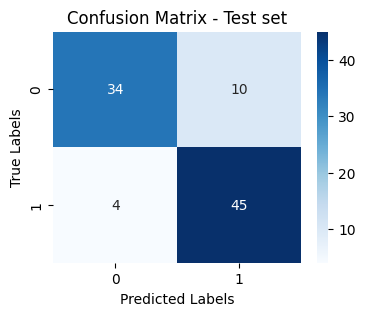

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix - Test set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()